<a href="https://colab.research.google.com/github/wladimirLefebure/bigdata-wl/blob/master/Exo_planet_lab_wladimir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install astroquery
import numpy as np
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ticid = 388104525

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
388104525 11.6035 10.924   55.93342240979 -65.1938512272516    STAR
650419407 19.8667    nan 55.9404793138343 -65.1938949361536    STAR
650419610 18.9745    nan 55.9260110476915 -65.1882654071435    STAR
388104522 17.4523 16.367 55.9419878222376 -65.1997148561897    STAR
388104523 15.1995 14.574 55.9187712557504 -65.1990332327806    STAR


11

In [3]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-4-1      1      4   1
tess-s0002-3-4      2      3   4
tess-s0003-3-3      3      3   3
tess-s0004-4-2      4      4   2
tess-s0007-4-3      7      4   3
tess-s0010-4-4     10      4   4
tess-s0011-4-4     11      4   4


In [4]:
hdulist = Tesscut.get_cutouts(coord, 20)
hdulist[0].info()
hdulist[0][0].header['SECTOR']
#hdulist[1].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


1

In [0]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

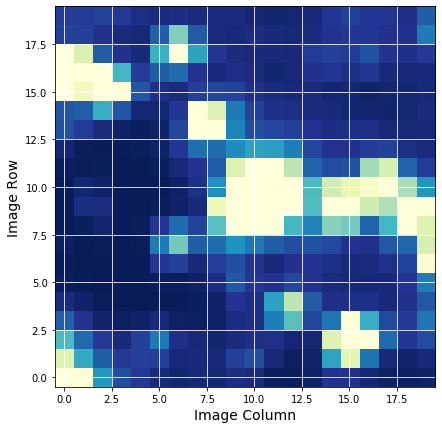

In [6]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)


In [0]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux


Text(0.5, 1.0, 'Flux in Photometric Aperture')

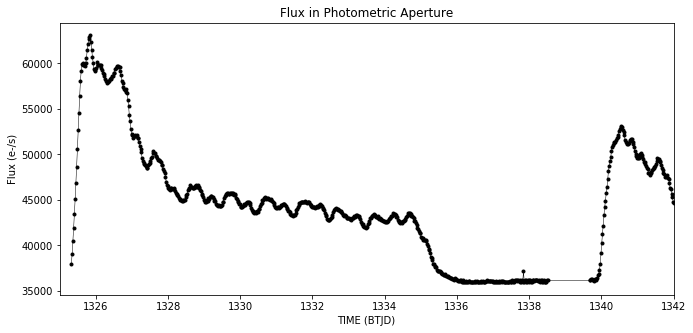

In [8]:
# Use all pixels in our aperture.
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
plt.xlim(1325,1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')

Text(0.5, 1.0, 'Background Flux')

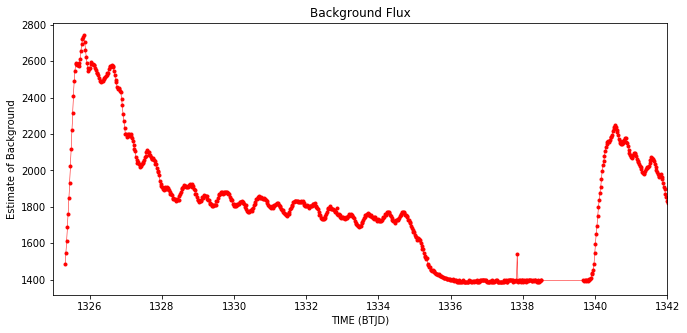

In [9]:
# Plot the flux change of the dimmest pixels by using percentile.
bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1325, 1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

Text(0.5, 1.0, 'Background Subtracted Flux')

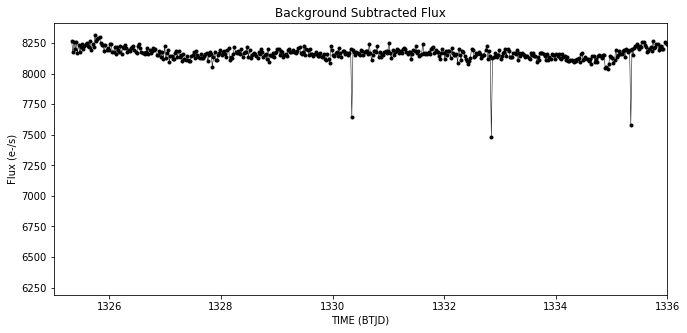

In [10]:
bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.xlim(1325, 1336)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')


In [0]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML

%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}

In [0]:
planet_name = "WASP-18 b"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))